The goal of this project is to classify Lego bricks using TensorFlow.

### Dataset:

The dataset can be found [here](https://www.kaggle.com/joosthazelzet/lego-brick-images/home) under GPL 2.

There are 16 different lego bricks. Each brick is selected in Mecabricks.com and next imported in collada (.dae) format in Blender, and rendered from 400 different angles.

### Method:

Since the data set is relatively small, we will use [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) module for data augmentation.

### Lessons learned from the previous experiment:

The first lesson I learned from the previous experiment, [blood cell classification](https://github.com/zxfsheep/deep-learning-lab/blob/master/blood_cell.ipynb), is that we should start with minimum noise given a tiny dataset. We can tune up the noise later by controlled augmentation. Furthermore, the target variation was very small in the blood cell dataset. For instance one of them has only 21 genuinly different images. In this experiment, even though each lego brick is unique in 3D, after projected to 2D at hundreds of different angles, they become genuinely different images for the NN to learn.

Another lesson I learned from the previous experiment is that, SeLu activation function really should not be used on a small or simple dataset. The same goes to batch normalization. The reason is that these require neuron-wise normalization across a batch or global set. With a simple dataset, there might not be much variation at many pixels, so the standard deviation could be very small or zero. Even if we take care of division by zero by adding a small constant to the denominator, the normalized values could be wild, and that led to divergence of the NN.

In [1]:
import os
from collections import defaultdict
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
plt.ion()
import gc
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import numpy as np
from my_util import show_graph, reset_graph

Organize all the images.

In [2]:
data_folder = os.path.join("dataset", "LEGO brick images")
train_folder = os.path.join(data_folder, "train")
valid_folder = os.path.join(data_folder, "valid")
lego_types = sorted([dirname for dirname in os.listdir(train_folder) 
                     if os.path.isdir(os.path.join(train_folder, dirname))])
lego_type_coding = {name : index for index, name in enumerate(lego_types)}
lego_types

['11214 Bush 3M friction with Cross axle',
 '18651 Cross Axle 2M with Snap friction',
 '2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '32123 half Bush',
 '3673 Peg 2M',
 '3713 Bush for Cross Axle',
 '3794 Plate 1X2 with 1 Knob',
 '6632 Technic Lever 3M']

In [3]:
train_images = defaultdict(list)
valid_images = defaultdict(list)

for lego_type in lego_types:
    train_dir = os.path.join(train_folder, lego_type)
    valid_dir = os.path.join(valid_folder, lego_type)
    for filename in os.listdir(train_dir):
        if filename.endswith(".png"):
            train_images[lego_type].append(os.path.join(train_dir, filename))
    for filename in os.listdir(valid_dir):
        if filename.endswith(".png"):
            valid_images[lego_type].append(os.path.join(valid_dir, filename))        

We take a look at train images. These PNG files have the 4th channel for opacity, which we simply get rid of for now.

(200, 200, 4)


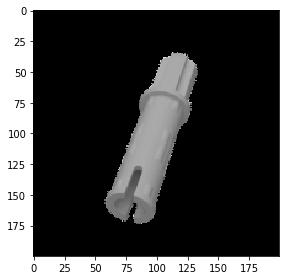

In [4]:
a = imread(train_images['11214 Bush 3M friction with Cross axle'][0])
print(a.shape)
imshow(a[:, :, [0,1,2]])

Lego brick type: 11214 Bush 3M friction with Cross axle


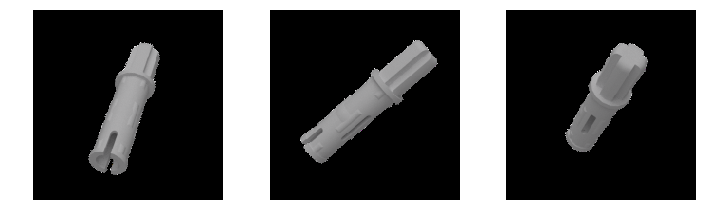

Lego brick type: 18651 Cross Axle 2M with Snap friction


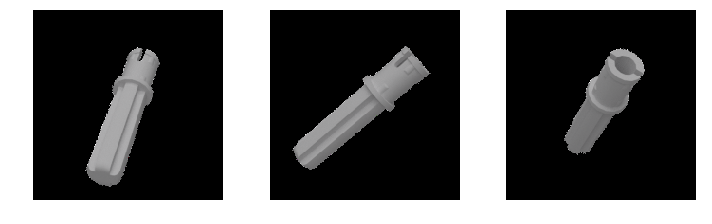

Lego brick type: 2357 Brick corner 1x2x2


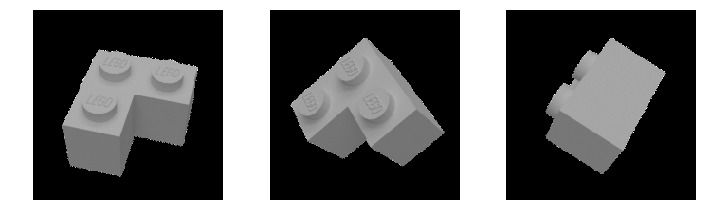

Lego brick type: 3003 Brick 2x2


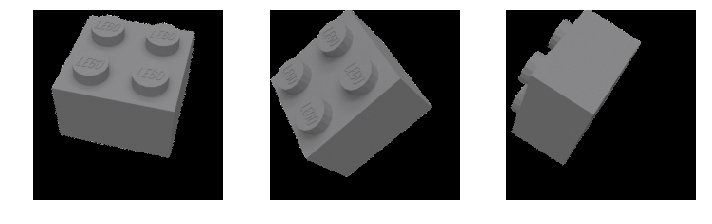

Lego brick type: 3004 Brick 1x2


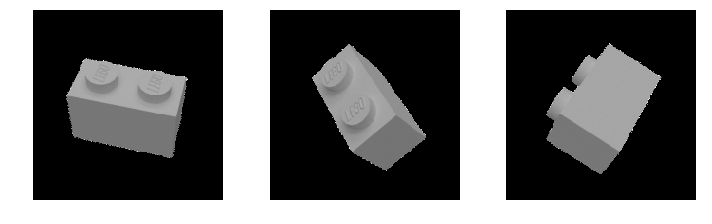

Lego brick type: 3005 Brick 1x1


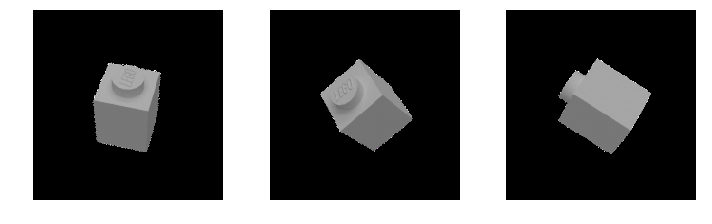

Lego brick type: 3022 Plate 2x2


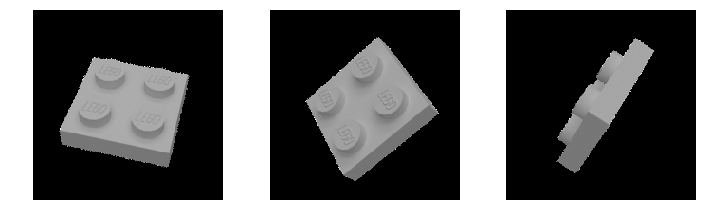

Lego brick type: 3023 Plate 1x2


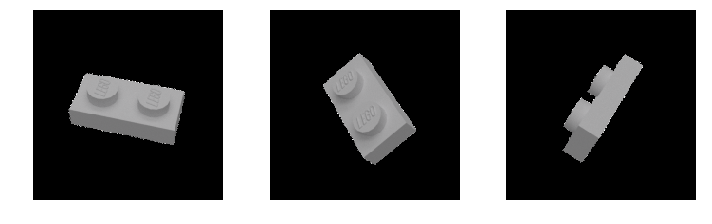

Lego brick type: 3024 Plate 1x1


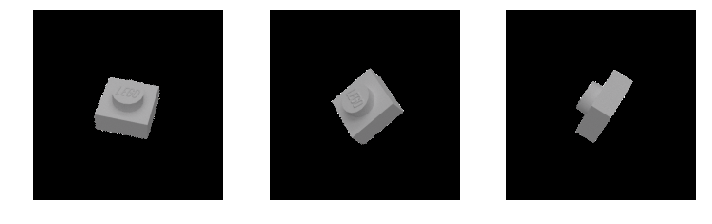

Lego brick type: 3040 Roof Tile 1x2x45deg


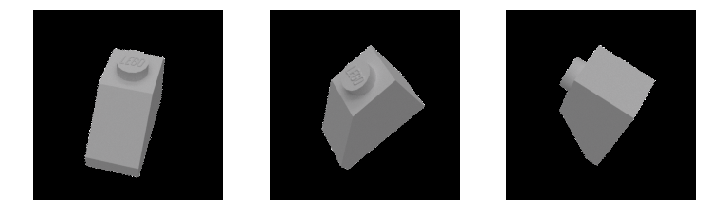

Lego brick type: 3069 Flat Tile 1x2


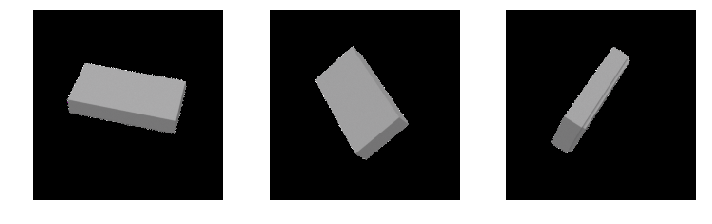

Lego brick type: 32123 half Bush


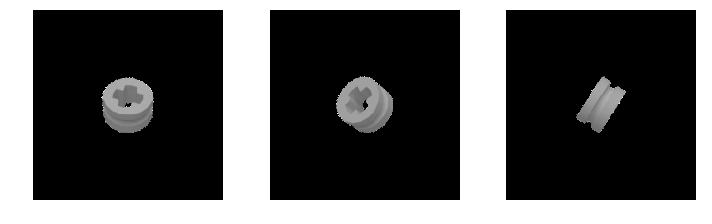

Lego brick type: 3673 Peg 2M


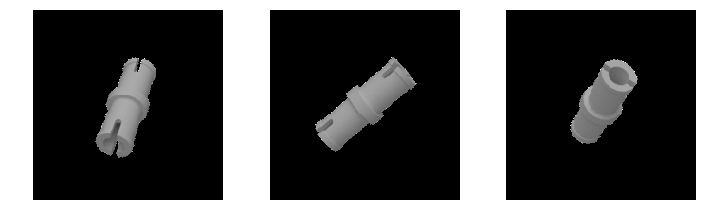

Lego brick type: 3713 Bush for Cross Axle


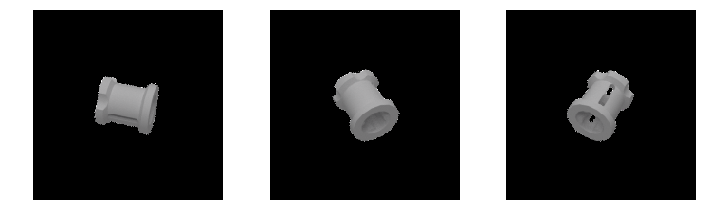

Lego brick type: 3794 Plate 1X2 with 1 Knob


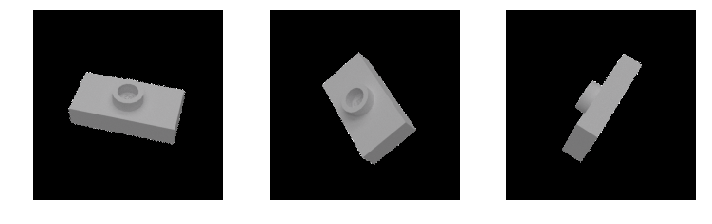

Lego brick type: 6632 Technic Lever 3M


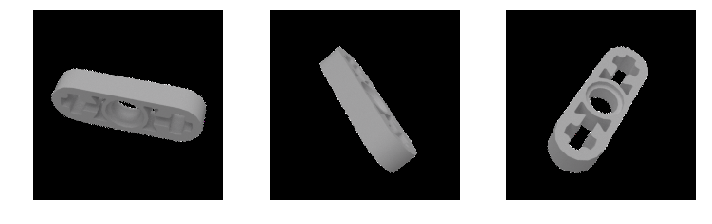

In [7]:
num = 3
for lego_type in lego_types:
    print(f"Lego brick type: {lego_type}")
    plt.figure(figsize=(10,5))
    for index, filepath in enumerate(train_images[lego_type][:num*77:77]):
        lego_image = imread(filepath)
        plt.subplot(100 + num * 10 + index + 1)
        imshow(lego_image[:, :, [0,1,2]])
        plt.axis("off")
    plt.show()

At first sight, they look very different. But there are actually many angles in the dataset where multiple types become very hard to distinguish.

We read in all images into numpy arrays:

In [144]:
train_feat = []
valid_feat = []
train_label = []
valid_label = []

for lego_type, samples in train_images.items():
    for samp in samples:
        train_feat.append(imread(samp)[:, :, :3])
        train_label.append(lego_type_coding[lego_type])
for lego_type, samples in valid_images.items():
    for samp in samples:
        valid_feat.append(imread(samp)[:, :, :3])
        valid_label.append(lego_type_coding[lego_type]) 

In [145]:
train_feat = np.stack(train_feat)
valid_feat = np.stack(valid_feat)

In [152]:
train_feat.dtype

dtype('uint8')

We will use eLu activation function.

SeLu will not work well because there are a lot of 0 padding in the training. We will augment the training data later, which makes normalizing during training and predicting complicated.

We save the normalized input to an `.npz` file, about 1.5GB.

In [154]:
np.savez_compressed(os.path.join(data_folder, 'np_data'), train_X = train_feat, 
                    train_y = np.asarray(train_label), valid_X = valid_feat, 
                    valid_y = np.asarray(valid_label))

Next time we can directly read in the numpy file.

In [9]:
with np.load(os.path.join(data_folder, 'np_data.npz')) as data:
    train_X = data["train_X"], 
    train_y = data["train_y"],
    valid_X = data["valid_X"],
    valid_y = data["valid_y"]

For some reason (probably a bug), the first three have an extra tuple layer...

In [10]:
train_X = (train_X[0] / 255).astype(np.float32)
train_y = train_y[0]
valid_X = (valid_X[0] / 255).astype(np.float32)
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(6379, 200, 200, 3) (6379,) (6379, 200, 200, 3) (6379,)


In [11]:
permutation = np.random.permutation(train_X.shape[0])
shuffled_train_X = train_X[permutation, :]
shuffled_train_y = train_y[permutation]
del train_X, train_y
gc.collect()

222

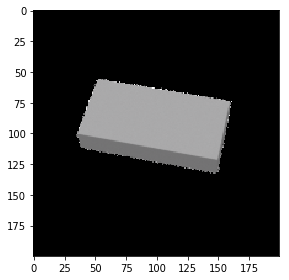

In [29]:
imshow(shuffled_train_X[0, :, :, :])

Now let us build a basic TensorFlow graph:

The 1st layer is a vanilla convolutional layer.

The 2nd layer is a depthwise separable convolutional layer with local response normalization.

The 3rd layer is a max pooling layer.

The 4th layer is another depthwise separable convolutional layer with local response normalization.

The 5th layer is another max pooling layer with dropout.

The 6th layer is a fully connected layer again with dropout.

The final layer is a fully connected layer outputing logits.

Some comments are in order:
* As mentioned above, I initially tried batch normalization, and it led to wild divergence. Then I realized it was a stupid move because the background is mostly constant, and led to blowup of values. There are no simple ways to get around, since we will also augment different pictures, so individual pixels could occasionally become active. Maybe we can add uniform randomness to the non-picture part, but that seems not worth it as it is adding completely useless information.

* As before, since I am running on a laptop, performance is important. The depthwise separable convolutional layers are particularly efficient without sacrificing too much performance. Consider a input tensor size $(w,h)$ with $f_i$ input channels and $f_o$ output channels, and filter kernel of size $(k, k)$. A traditional convolutional layer needs to compute $w\times h\times k^2\times f_i\times f_o$ times, while a depthwise separable layer with channel multiplier 2 only needs $w\times h\times f_i\times (2k^2+f_o)$ computations. 

* The two dropouts help to overcome overfitting, as our training data is quite small.

In [12]:
reset_graph()
height = 200
width = 200
channels = 3
training = tf.placeholder_with_default(False, shape=(), name='training')

entire_X = tf.placeholder(shuffled_train_X.dtype, shape = (None, 200, 200, 3), name = "entire_X")
entire_y = tf.placeholder(shuffled_train_y.dtype, shape = (None), name = "entire_y")
X = tf.placeholder(tf.float32, shape = (None, 200, 200, 3), name = "X")
y = tf.placeholder(tf.int32, shape = (None), name = "y")
dataset = tf.data.Dataset.from_tensor_slices((entire_X, entire_y))
dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size = 100))
batch_size = 50
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
with tf.name_scope("inputs"):
    next_element = iterator.get_next()

layers = []
#0 conv2d
layers.append({'channel_out' : 32, 'kernel_size' : 5, 'stride' : 1, 'name' : 'conv1', 'padding' : 'SAME'})
#1 separable conv2d + local response normalization
layers.append({'channel_out' : 64, 'kernel_size' : 3, 'stride' : 2, 'multiplier' : 2, 'name' : 'sep1', 
               'padding' : 'SAME', 'depth_radius' : 2, 'alpha': 0.01})
#2 maxpooling
layers.append({'kernel_size' : 3, 'stride' : 2 , 'name' : 'max1' , 'padding' : 'VALID'})

#3 separable conv2d + local_response_normalization
layers.append({'channel_out' : 128, 'kernel_size' : 3, 'stride' : 1, 'multiplier' : 2, 'name' : 'sep2', 
               'padding' : 'SAME', 'depth_radius' : 2, 'alpha': 0.01})
#4 maxpooling + dropout
layers.append({'kernel_size' : 3, 'stride' : 2 , 'name' : 'max2' , 'padding' : 'VALID', 'dropout' : 0.2})
#5 dense + dropout
layers.append({'channel_out' : 192, 'dropout' : 0.4, 'name' : 'full1'})
#6 dense + softmax
layers.append({'channel_out' : 16, 'name' : 'output'})

config = layers[0]
layer = tf.layers.conv2d(X, filters = config['channel_out'], kernel_size = config['kernel_size'], strides = config['stride'], padding = config['padding'], activation=tf.nn.elu, name = config['name'], kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))

config = layers[1]
layer = tf.layers.separable_conv2d(layer, filters = config['channel_out'], kernel_size = config['kernel_size'], strides = config['stride'], padding = config['padding'], activation=tf.nn.elu, name = config['name'], depthwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'), pointwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'), depth_multiplier = config['multiplier'])
with tf.name_scope(config['name']):
    layer = tf.nn.local_response_normalization(layer, depth_radius = config['depth_radius'], alpha = config['alpha'])
    
config = layers[2]
layer = tf.layers.max_pooling2d(layer, pool_size = config['kernel_size'], strides = config['stride'], padding = config['padding'], name = config['name'])

config = layers[3]
layer = tf.layers.separable_conv2d(layer, filters = config['channel_out'], kernel_size = config['kernel_size'], strides = config['stride'], padding = config['padding'], activation=tf.nn.elu, name = config['name'], depthwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'), pointwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'), depth_multiplier = config['multiplier'])
with tf.name_scope(config['name']):
    layer = tf.nn.local_response_normalization(layer, depth_radius = config['depth_radius'], alpha = config['alpha'])
    
config = layers[4]
layer = tf.layers.max_pooling2d(layer, pool_size = config['kernel_size'], strides = config['stride'], padding = config['padding'], name = config['name'])
layer = tf.layers.dropout(layer, config['dropout'], name = config['name'], training = training)         
config = layers[5]   
layer = tf.layers.flatten(layer, name = config['name'])
layer = tf.layers.dense(layer, config['channel_out'], activation=tf.nn.elu, name = config['name'], kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))
layer = tf.layers.dropout(layer, config['dropout'], name = config['name'], training = training) 
    
config = layers[6]
layer = tf.layers.flatten(layer, name = config['name'])
logits = tf.layers.dense(layer, config['channel_out'], name = config['name'], kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))
with tf.name_scope(config['name']):
    y_prob = tf.nn.softmax(logits)
    
with tf.name_scope("train"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("valid"):
    correct = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Let us define an augmentation function using TensorFlow [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) module. We will randomly rotate, zoom in or out, and randomly shift the brick up or down and left or right.

The given validation set is actually centered and has correct sizes, so this augmentation might not be necessary for this specific validation set. But it is still done for two reasons:

1. We do not want to overfit to the training set;

2. The NN will not be that useful or interesting if it cannot recognize a rotated and shifted brick. 

In [13]:
def augment(im, height = 200, width = 200, shift_limit = 25, zoom_limit = 0.2):
    zoom = tf.random_uniform(shape=(), minval=- zoom_limit, maxval= + zoom_limit)
    rot = tf.random_uniform(shape=(), minval=0, maxval=3, dtype = tf.int32)
    # Randomly rotate
    im = tf.image.rot90(im, rot)
    new_side = tf.cast(height * (1 + zoom), tf.int32)
    # Randomly zoom in or out
    im = tf.image.resize_images(im, [new_side, new_side])
    center = tf.cast(new_side / 2, tf.int32)
    # When zoomed in, cut out a square whose center can be shifted by maximum shift_limit
    # When zoomed out, randomly pad by zero
    offset_height_min = tf.cast(tf.maximum(0, tf.subtract(center, tf.cast(height / 2 + shift_limit, tf.int32))), tf.int32)
    offset_height_max = tf.cast(tf.minimum(new_side - height, tf.subtract(center, tf.cast(height / 2 - shift_limit, tf.int32))), tf.int32)
    offset_height = tf.random_uniform(shape=(), minval=offset_height_min, maxval=tf.maximum(offset_height_min + 1, offset_height_max), dtype = tf.int32)             
    offset_width = tf.random_uniform(shape=(), minval=offset_height_min, maxval=tf.maximum(offset_height_min + 1, offset_height_max), dtype = tf.int32)
    offset_height_v2 = tf.random_uniform(shape=(), minval=0, maxval=tf.maximum(1, tf.subtract(height, new_side+1)), dtype = tf.int32)
    offset_width_v2 = tf.random_uniform(shape=(), minval=0, maxval=tf.maximum(1, tf.subtract(height, new_side+1)), dtype = tf.int32)                            
    im = tf.cond(tf.greater(zoom, 0), lambda: tf.image.crop_to_bounding_box(im, offset_height, offset_width, height, width), lambda: tf.image.pad_to_bounding_box(im, offset_height_v2, offset_width_v2, height, width))
    return im

with tf.name_scope("util"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    temp_X = tf.placeholder(tf.float32, shape=[None, None, 3])
    augmented_image_op = augment(temp_X)

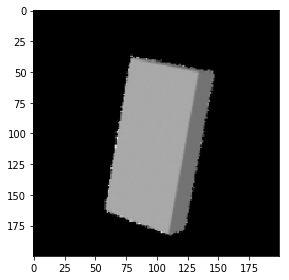

In [28]:
#import time
#reset_graph(seed = int(time.clock()))

temp_X = tf.placeholder(tf.float32, shape=[None, None, 3])
augmented_image_op = augment(temp_X)

with tf.Session() as sess:
    augmented_image = augmented_image_op.eval(feed_dict={temp_X: shuffled_train_X[0, :, :, :]})

imshow(augmented_image)

We split the validation set into small batches so that they can fit in the GPU memory. There is really no reason to shuffle them here since I am using the whole validation set each time. But one could use a random subset of them to speed up validation.

In [15]:
np.random.seed(2018)
idx = np.random.permutation(valid_X.shape[0])
subidx = np.array_split(idx, 320)
def compute_valid(f):
    ave = 0
    for i in range(320):
        samp_X = valid_X[subidx[i], :]
        samp_y = valid_y[subidx[i]]
        ave += f.eval(feed_dict={X: samp_X, y: samp_y}) *len(subidx[i]) / len(idx)
    return ave    

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9  

Now we train the model.

In [ ]:
batch_per_epoch = 60

best_loss = np.inf
best_accu = 0
no_progress = 0
tolerance = 400
tally = 0

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session(config=config) as sess:
    init.run()
    sess.run(iterator.initializer, feed_dict={entire_X: shuffled_train_X,
                                              entire_y: shuffled_train_y})

    while True:
        tally += 1
        if no_progress > tolerance:
            print("Early stopping!")
            break
        for iter in range(batch_per_epoch):
            batch_X, batch_y = sess.run(next_element)
            batch_X = [augmented_image_op.eval(feed_dict={temp_X: i}) for i in batch_X]
            sess.run([training_op, update_ops], feed_dict={X : batch_X, y : batch_y, training: True})
        train_accuracy = accuracy.eval(feed_dict={X: batch_X, y: batch_y})
        valid_accuracy = compute_valid(accuracy)            
        valid_loss = compute_valid(loss)
        
        print(f"Epoch {tally}, train accuracy: {train_accuracy * 100:.4f}%, valid accuracy: {valid_accuracy * 100:.4f}%, valid loss: {valid_loss:.6f}")

        if (valid_loss >= best_loss) and (valid_accuracy <= best_accu):
            no_progress += 1
        else:
            if valid_loss < best_loss:
                best_loss = valid_loss
                no_progress = 0
                best_loss_model_path = saver.save(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
            if valid_accuracy > best_accu:
                best_accu = valid_accuracy
                no_progress = 0
                best_accu_model_path = saver.save(sess, os.path.join(data_folder, "best_accu_model", "save.ckpt"))

    if best_accu_model_path:
        saver.restore(sess, os.path.join(data_folder, "best_accu_model", "save.ckpt"))
    valid_accuracy = compute_valid(accuracy)
    print("Final best accuracy on validation set:", valid_accuracy)
    if best_loss_model_path:
        saver.restore(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
    valid_accuracy = compute_valid(accuracy)
    print("Final accuracy of best loss model on validation set:", valid_accuracy)
    

The Jupyter notebook has memory issues, so I ran the training part in command line. I trained for a couple of days. Let us restore the model with best loss on validation set.

In [20]:
with tf.name_scope("valid2"):
    correct2 = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 2)
    accuracy2 = tf.reduce_mean(tf.cast(correct2, tf.float32))

with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
    valid_accuracy = compute_valid(accuracy)
    print(f"Final accuracy on validation set with best loss model: {valid_accuracy*100:.4f}%")
    valid_accuracy = compute_valid(accuracy2)
    print(f"Final top 2 accuracy on validation set with best loss model: {valid_accuracy*100:.4f}%")

INFO:tensorflow:Restoring parameters from dataset\LEGO brick images\best_loss_model\save.ckpt
Final accuracy on validation set with best loss model: 99.9216%
Final top 2 accuracy on validation set with best loss model: 100.0000%


So it did pretty well! For top 1 prediction we reached 99.92% accuracy, and top 2 predictions are all correct.

For curiosity, let us look at for which pictures the NN made mistakes for top1 prediction:

INFO:tensorflow:Restoring parameters from dataset\LEGO brick images\best_loss_model\save.ckpt
Type 11214 Bush 3M friction with Cross axle mistaken for type 3023 Plate 1x2!


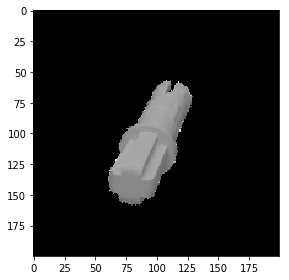

Type 3040 Roof Tile 1x2x45deg mistaken for type 3005 Brick 1x1!


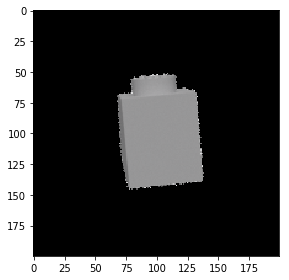

Type 3040 Roof Tile 1x2x45deg mistaken for type 3005 Brick 1x1!


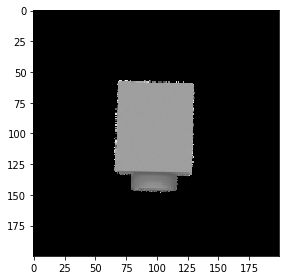

Type 3069 Flat Tile 1x2 mistaken for type 6632 Technic Lever 3M!


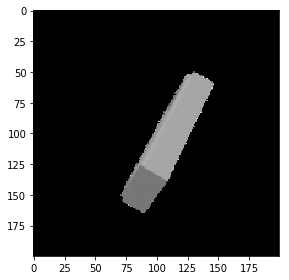

Type 3673 Peg 2M mistaken for type 18651 Cross Axle 2M with Snap friction!


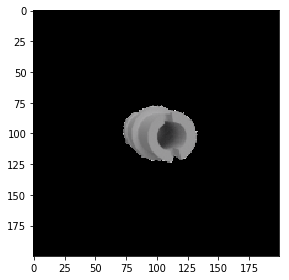

In [29]:
_, pred = tf.nn.top_k(logits, 1)

with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
    for i in range(valid_X.shape[0]):
        samp_X = valid_X[[i], :]
        samp_y = valid_y[i]
        top1 = pred.eval(feed_dict={X: samp_X})[0,0]
        if (top1 != samp_y):
            print(f"Type {lego_types[samp_y]} mistaken for type {lego_types[top1]}!")
            imshow(samp_X[0])
            plt.show()

So we see that in the 2nd, 3rd and 5th cases, even human eyes cannot really tell clearly. But the 1st and 4th cases are obvious for me to tell, and it is peculiar why the NN made the mistake. Maybe the ambiguity comes from the augmentation of training set.

---

Now let us increase the difficulty. We will randomly rotate, zoom in or out and shift each test picture independently, and examine the performance of the NN.

In [30]:
np.random.seed(2018)
idx = np.arange(valid_X.shape[0])
subidx = np.array_split(idx, 320)
def compute_valid_augmented(f):
    ave = 0
    for i in range(320):
        samp_X = valid_X[subidx[i], :]
        samp_X = [augmented_image_op.eval(feed_dict={temp_X: i}) for i in samp_X]
        samp_y = valid_y[subidx[i]]
        ave += f.eval(feed_dict={X: samp_X, y: samp_y}) *len(subidx[i]) / len(idx)
    return ave    

with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
    valid_accuracy = compute_valid_augmented(accuracy)
    print(f"Final accuracy on augmented validation set with best loss model: {valid_accuracy*100:.4f}%")
    valid_accuracy = compute_valid_augmented(accuracy2)
    print(f"Final top 2 accuracy on augmented validation set with best loss model: {valid_accuracy*100:.4f}%")

INFO:tensorflow:Restoring parameters from dataset\LEGO brick images\best_loss_model\save.ckpt
Final accuracy on augmented validation set with best loss model: 97.0999%
Final top 2 accuracy on augmented validation set with best loss model: 99.7021%


So this time the top 1 accuracy is 97.10% and the top 2 accuracy is 99.70%. This is slightly worse than above, but it is actually quite amazing to me, considering the fact that the space of test images becomes much larger after the random augmentation.

---

Finally some philosophical thoughts. One can argue that the NN has so many parameters that the trained NN basically stored the whole training set. It is kind of cheating by memorizing the answers. But there are some crucial differences:

* The NN makes prediction by simply running once with the picture as an input. It is not mechanically comparing the input pixel by pixel with all the training images. So the prediction procedure is much much faster.

* The NN can generalize to a random augmentation of the input picture pretty well. This will be infinitely harder if images are compared mechanically.

* And isn't this how human brain works? We see pictures, and memorize them to some extent, but we are able to recognize similar instances almost immediately, instead of comparing it to every picture we have seen before.